## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace questions marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

print("Before: ", type(data['fare'][0]))
data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')
print("After: ", type(data['fare'][0]))

Before:  <class 'str'>
After:  <class 'numpy.float64'>


In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
vars_num = [var for var in data.columns if np.dtype(data[var]) != 'O'] # fill your code here

vars_cat = [var for var in data.columns if np.dtype(data[var]) == 'O'] # fill your code here

print('Numerical variables: ', vars_num)
print('Categorical variables: ', vars_cat)
print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Numerical variables:  ['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare']
Categorical variables:  ['sex', 'cabin', 'embarked', 'title']
Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [12]:
# first in numerical variables: for each variable, these are the indices of the missing values, in a dictionary
vars_num_missing = dict()
for var in vars_num:
    vars_num_missing[var] = data[data[var].isna()].index

In [13]:
# now in categorical variables: for each variable, these are the indices of the missing values, in a dictionary
vars_cat_missing = dict()
for var in vars_cat:
    vars_cat_missing[var] = data[data[var].isna()].index

### Determine cardinality of categorical variables

In [14]:
vars_cat_cardinality = dict()
for var in vars_cat:
    vars_cat_cardinality[var] = len(data[var].unique())
vars_cat_cardinality

{'sex': 2, 'cabin': 182, 'embarked': 4, 'title': 5}

### Determine the distribution of numerical variables

We will make a simple histogram for each of the numerical variables to see the distribution of each.

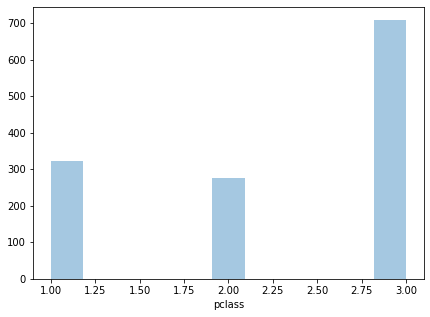

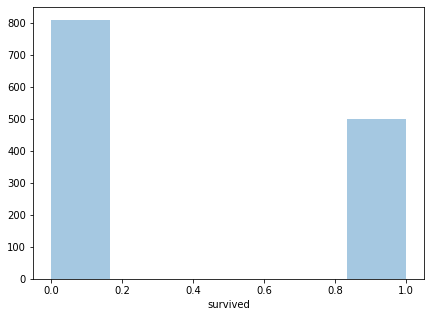

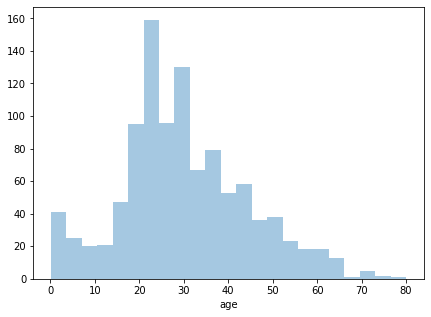

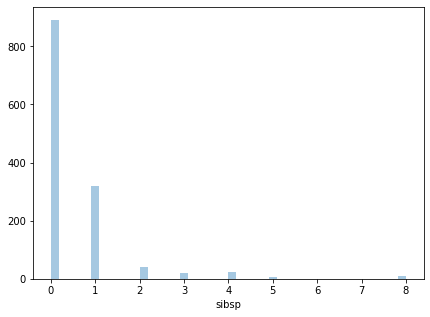

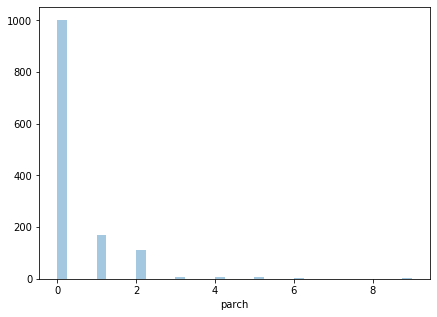

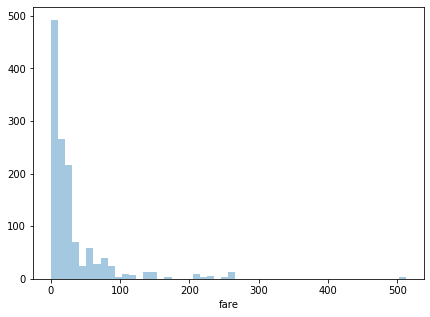

In [15]:
for var in vars_num:
    plt.figure(figsize=(7,5))
    sns.distplot(data[~data[var].isna()][var], kde=False)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

Notice that the letter is ALWAYS the first character in the string value for the `cabin` variable.

In [63]:
def get_cabin_letter(df):
    df['cabin'] = df['cabin'].str[0]
    return df
    
X_train = get_cabin_letter(X_train)
X_test = get_cabin_letter(X_test)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [64]:
if 'survived' in vars_num:
    vars_num.remove('survived')

def fillna_num_vars(df):
    for var in vars_num:
        if var+'_na' not in df.columns:
            df[var+'_na'] = df[var].isna().astype(int)
        df[var] = df[var].fillna(np.nanmedian(df[var]))
    return df
    
X_train, X_test = fillna_num_vars(X_train), fillna_num_vars(X_test)

### Replace Missing data in categorical variables with the string **Missing**

In [65]:
def fillna_cat_vars(df, fillna_str):
    for var in vars_cat:
        df[var] = df[var].fillna(fillna_str)
    return df

X_train, X_test = fillna_cat_vars(X_train, 'Missing'), fillna_cat_vars(X_test, 'Missing')
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,pclass_na,age_na,sibsp_na,parch_na,fare_na
1118,3,male,25.0,0,0,7.9250,Missing,S,Mr,0,0,0,0,0
44,1,female,41.0,0,0,134.5000,E,C,Miss,0,0,0,0,0
1072,3,male,28.0,0,0,7.7333,Missing,Q,Mr,0,1,0,0,0
1130,3,female,18.0,0,0,7.7750,Missing,S,Miss,0,0,0,0,0
574,2,male,29.0,1,0,21.0000,Missing,S,Mr,0,0,0,0,0


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [66]:
def remove_rare_labels(df, var, pct):
    percents = df.groupby(var)['age'].count() / len(df)
    rare_labels = percents[percents < 0.05].index
    df[var] = np.where(df[var].isin(rare_labels), 'Rare', df[var])
    return df
    
for var in vars_cat:
    X_train = remove_rare_labels(X_train, var, 0.05)
    X_test = remove_rare_labels(X_test, var, 0.05)

In [68]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,pclass_na,age_na,sibsp_na,parch_na,fare_na
1118,3,male,25.0,0,0,7.9250,Missing,S,Mr,0,0,0,0,0
44,1,female,41.0,0,0,134.5000,Rare,C,Miss,0,0,0,0,0
1072,3,male,28.0,0,0,7.7333,Missing,Q,Mr,0,1,0,0,0
1130,3,female,18.0,0,0,7.7750,Missing,S,Miss,0,0,0,0,0
574,2,male,29.0,1,0,21.0000,Missing,S,Mr,0,0,0,0,0


In [69]:
X_test.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,pclass_na,age_na,sibsp_na,parch_na,fare_na
1139,3,male,38.0,0,0,7.8958,Missing,S,Mr,0,0,0,0,0
533,2,female,21.0,0,1,21.0000,Missing,S,Miss,0,0,0,0,0
459,2,male,42.0,1,0,27.0000,Missing,S,Mr,0,0,0,0,0
1150,3,male,26.0,0,0,14.5000,Missing,S,Mr,0,1,0,0,0
393,2,male,25.0,0,0,31.5000,Missing,S,Mr,0,0,0,0,0


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [80]:
# This function will manually perform one-hot encoding for a given categorical variable
def onehot_encode(df, var):
    df = df.copy()
    for label in df[var].unique()[1:]:
        df[var+'_'+label] = np.where(df[var] == label, 1, 0)
    df = df.drop(var, axis=1)
    return df

In [83]:
for var in vars_cat:
    X_train = onehot_encode(X_train, var)
    X_test = onehot_encode(X_test, var)

In [85]:
X_train.head()

,pclass,age,sibsp,parch,fare,pclass_na,age_na,sibsp_na,parch_na,fare_na,sex_female,cabin_Rare,cabin_C,embarked_C,embarked_Q,embarked_Rare,title_Miss,title_Mrs,title_Rare
1118,3,25.0,0,0,7.9250,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44,1,41.0,0,0,134.5000,0,0,0,0,0,1,1,0,1,0,0,1,0,0
1072,3,28.0,0,0,7.7333,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1130,3,18.0,0,0,7.7750,0,0,0,0,0,1,0,0,0,0,0,1,0,0
574,2,29.0,1,0,21.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [86]:
X_test.head()

,pclass,age,sibsp,parch,fare,pclass_na,age_na,sibsp_na,parch_na,fare_na,sex_female,cabin_Rare,cabin_C,embarked_C,embarked_Q,title_Miss,title_Rare,title_Master,title_Mrs
1139,3,38.0,0,0,7.8958,0,0,0,0,0,0,0,0,0,0,0,0,0,0
533,2,21.0,0,1,21.0000,0,0,0,0,0,1,0,0,0,0,1,0,0,0
459,2,42.0,1,0,27.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1150,3,26.0,0,0,14.5000,0,1,0,0,0,0,0,0,0,0,0,0,0,0
393,2,25.0,0,0,31.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Scale the variables

- Use the standard scaler from Scikit-learn

In [87]:
scaler = StandardScaler()
scaler.fit(X_train);

StandardScaler(copy=True, with_mean=True, with_std=True)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [99]:
# Notice that the regularization is inversed in the input to LogisticRegression
model = LogisticRegression(C=1/0.0005, solver='liblinear', random_state=0)
model.fit(X_train, y_train)

LogisticRegression(C=2000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

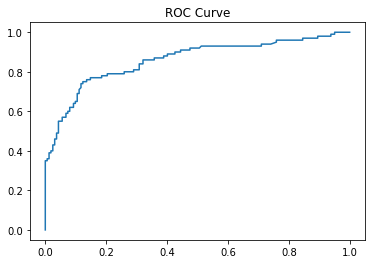

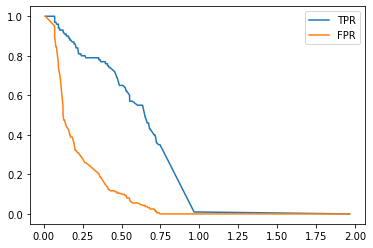

In [142]:
from sklearn.metrics import roc_curve

# Calculate ROC and choose best threshold
y_score = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_score)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
plt.title("ROC Curve")
plt.plot(fpr, tpr, label = "ROC Curve");

plt.figure()
plt.plot(thresholds, tpr, label="TPR")
plt.plot(thresholds, fpr, label="FPR")
plt.legend();

In [144]:
# We see that a threshold of about 0.4 is best
preds = y_score > 0.4
accuracy = accuracy_score(y_test, preds)


print("accuracy:", accuracy)
print("roc-auc:", roc_auc)

accuracy: 0.8206106870229007
roc-auc: 0.8587962962962963


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignment!!**